# PSD decimation
In this notebook, we investigate the effect of decimation on noisy data. In frequency
domain, we assume the data in each bin to consist of signal plus noise,
$$d_i = h_i + n_i.$$
We assume the noise to be Gaussian, with a variance determined by the PSD,
$$n_i \sim
\mathcal{N}\left(\mu_i = 0,\,\sigma_i^2 = {\rm PSD}_i \cdot \hat{\sigma}^2\right)
\cdot i\mathcal{N}\left(\mu_i = 0,\,\sigma_i^2 = {\rm PSD}_i \cdot \hat{\sigma}^2\right).
$$
The power spectral density (PSD) is a property of the detector, and the term
$\hat{\sigma} = \sqrt{\frac{w}{4\Delta f}}$ (referred to as `noise_std` within dingo)
depends on the data conditioning, specifically on the window factor $w$ and the
frequency resolution $\Delta f$.

In the derivations below, we only consider the real part of the noise for simplicity,
all statements apply to the imaginary part of the noise analogously. We thus write
$$n_i \sim
\mathcal{N}\left(\mu_i = 0,\,\sigma_i^2 = {\rm PSD}_i \cdot \hat{\sigma}^2\right).
$$


## Decimation (non-whitened data)
We decimate the GW data by averaging nearby frequency bins
$$
\bar{d}_j = \frac{1}{N_j} \sum_{i = i_j^-}^{i_j^+}
\left(h_i + n_i\right)
= \bar{h}_j + \bar{n}_j,
\qquad i_j^\pm = i_j \pm (N_j - 1) / 2,
$$
where the decimated noise is given by a sum of $N_j$ gaussian random variables with
variances $\sigma_i^2$. The sum of $N_j$ gaussian random variables is normally distributed
$$
\bar{n}_j \sim \frac{1}{N_j}\mathcal{N}\left(\sum \mu_i,\, \sum \sigma_i^2\right)
= \mathcal{N}\left(\frac{\sum \mu_i}{N_j},\, \frac{\sum \sigma_i^2}{N_j^2}\right)
= \mathcal{N}\left(0,\, \frac{\sum \sigma_i^2}{N_j^2}\right).
$$
The noise variance of bin $j$ in the decimated domain is thus given by
$$
\bar{\sigma}_j = \frac{1}{N_j^2} \sum {\rm PSD}_i \cdot \hat{\sigma}^2
= \frac{\hat{\sigma}^2}{N_j} \cdot \frac{\sum {\rm PSD}_i}{N_j}
= \frac{w}{4\Delta f\cdot N_j} \cdot \frac{\sum {\rm PSD}_i}{N_j}
= \frac{w}{4\Delta f_j\cdot} \cdot \overline{\rm PSD}_i
= \hat{\sigma}_j^2 \cdot \overline{\rm PSD}_i,
$$
where we used that the frequency resolution in decimation band $j$ is related to the
frequency resolution of the base domain via
$$
\Delta f_j = \Delta f \cdot N_j.
$$
We can therefore simply decimate the PSD used for whitening in the same way as we
decimate the data, and adjust the `noise_std` $\hat{\sigma}_j$ for the updated
frequency resolution $\Delta f_j$.

In [83]:
from bilby.gw.detector import PowerSpectralDensity
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

from dingo.gw.domains import build_domain
from dingo.gw.noise.asd_dataset import ASDDataset
from dingo.gw.gwutils import get_mismatch

In [12]:
domain_dict = {
    "type": "MultibandedFrequencyDomain",
    "bands": [
        [20.001953125, 20.462890625, 0.0078125],
        [20.474609375, 28.240234375, 0.015625],
        [28.263671875, 37.107421875, 0.03125],
        [37.154296875, 50.591796875, 0.0625],
        [50.685546875, 62.185546875, 0.125],
        [62.373046875, 114.623046875, 0.25],
        [114.998046875, 234.498046875, 0.5],
        [235.248046875, 389.248046875, 1.0],
        [390.748046875, 1022.748046875, 2.0],
    ],
    "base_domain": {
        "type": "FrequencyDomain",
        "f_min": 20.0,
        "f_max": 1024.0,
        "delta_f": 0.00390625,
        "window_factor": 1.0,
    },
    "window_factor": 1.0,
}
mfd = build_domain(domain_dict)
ufd = mfd.base_domain

In [2]:
print(mfd.base_domain.delta_f)
print(mfd._delta_f_bands / mfd.decimation_inds_bands[:,-1])
print(mfd._delta_f_bands - (mfd.base_domain.delta_f * mfd.decimation_inds_bands[:,-1]))

0.00390625
[0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
psd = PowerSpectralDensity(asd_file="aLIGO_ZERO_DET_high_P_asd.txt")

In [4]:
psd_interp = interp1d(
    psd.frequency_array, psd.psd_array, bounds_error=False, fill_value=np.inf
)
psd_array_ufd = psd_interp(ufd.sample_frequencies)
psd_array_ufd = ufd.update_data(psd_array_ufd, low_value=1e-44)
asd_array_ufd = psd_array_ufd ** 0.5

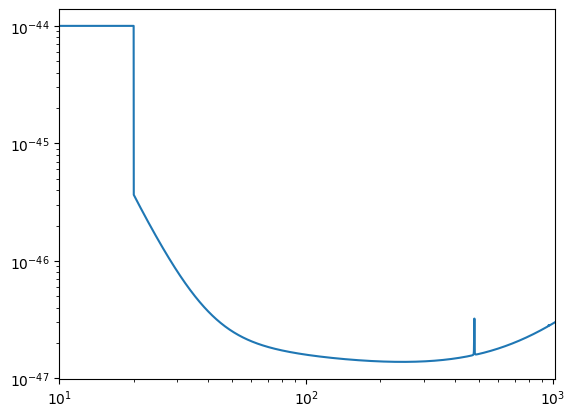

In [5]:
plt.plot(mfd.base_domain(), psd_array_ufd)
plt.xlim((10, ufd.f_max))
plt.yscale("log")
plt.xscale("log")
plt.show()

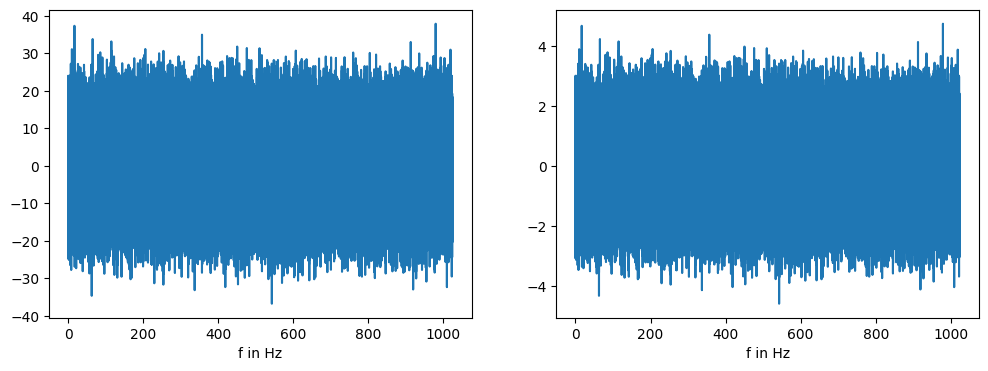

In [6]:
# generate noise, colored with this PSD
n = 100
noise_ufd = (
    (np.random.randn(n, len(ufd)) + 1j * np.random.randn(n, len(ufd)))
    * asd_array_ufd
    * ufd.noise_std
)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12,4))
ax1.plot(ufd(), noise_ufd[0].real / asd_array_ufd)
ax2.plot(ufd(), noise_ufd[0].real / (asd_array_ufd * ufd.noise_std))
ax1.set_xlabel("f in Hz")
ax2.set_xlabel("f in Hz")
plt.show()

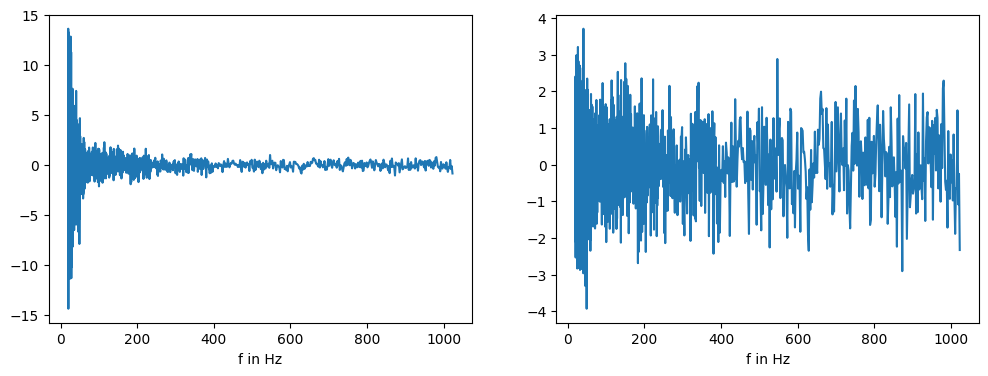

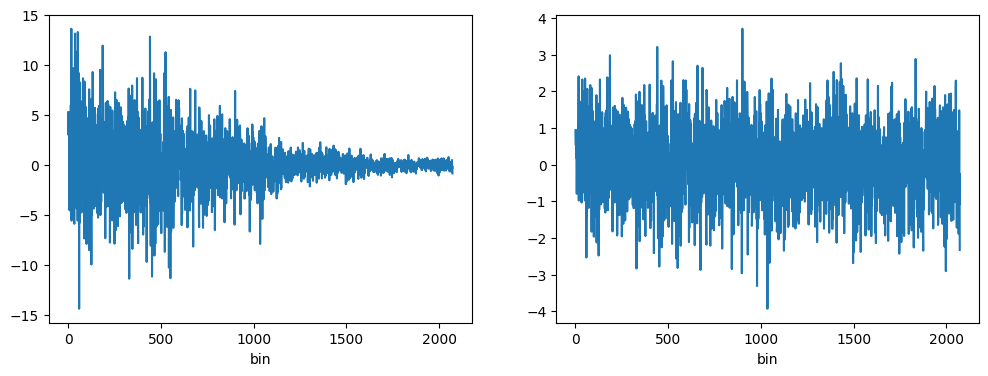

In [7]:
psd_array_mfd = mfd.decimate(psd_array_ufd)
asd_array_mfd = psd_array_mfd ** 0.5
noise_mfd = mfd.decimate(noise_ufd)
# mfd_noise_std = np.sqrt(1.0) / np.sqrt(4.0 * mfd._delta_f)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12,4))
ax1.plot(mfd(), noise_mfd[0].real / asd_array_mfd)
ax2.plot(mfd(), noise_mfd[0].real / (asd_array_mfd * mfd.noise_std))
ax1.set_xlabel("f in Hz")
ax2.set_xlabel("f in Hz")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12,4))
ax1.plot(noise_mfd[0].real / asd_array_mfd)
ax2.plot(noise_mfd[0].real / (asd_array_mfd * mfd.noise_std))
ax1.set_xlabel("bin")
ax2.set_xlabel("bin")
plt.show()

In [8]:
# check the noise std in each bin
noise_norm = noise_mfd / (asd_array_mfd * mfd.noise_std)
print(
    f"Noise std across all bands: {np.std(noise_norm.real):.3f} (real), "
    f"{np.std(noise_norm.imag):.3f} (imag).\n"
)
lower = 0
print("Band\t\tstd (real)\tstd (imag)")
for idx, upper in enumerate(np.cumsum(mfd._num_bins_bands)):
    # print(np.std(mfd._delta_f[lower:upper]))
    print(
        f"{idx}\t\t\t"
        f"{np.std(noise_norm[...,lower:upper].real):.3f}\t\t",
        f"{np.std(noise_norm[...,lower:upper].imag):.3f}",
    )
    lower = upper

Noise std across all bands: 1.001 (real), 0.998 (imag).

Band		std (real)	std (imag)
0			1.012		 1.005
1			0.999		 0.992
2			1.002		 1.000
3			1.005		 0.992
4			1.011		 0.999
5			0.990		 1.001
6			0.996		 0.998
7			1.005		 1.012
8			1.003		 0.997


## Decimation (whitened data)

Whitened GW data $d^{\rm w}_i$ is defined as
$$
d^{\rm w}_i = \frac{d_i}{{\rm ASD}_i} = \frac{h_i}{{\rm ASD}_i} + \frac{n_i}{{\rm
ASD}_i} =
h^{\rm
w}_i + n^{\rm w}_i,
$$
with amplitude spectral density
$$
{\rm ASD}_i = \sqrt{{\rm PSD}_i}.
$$
By construction, the whitened noise has a constant variance $\hat{\sigma}^2$,
$$n_i \sim
\mathcal{N}\left(\mu_i = 0,\,\sigma_i^2 = \hat{\sigma}^2\right),
$$
and is thus equally distributed for all bins $i$. The decimated whitened noise
therefore has a variance of
$$
\overline{\sigma^{\rm w}}_j = \frac{1}{N_j^2} \sum \hat{\sigma}^2
= \frac{\hat{\sigma}^2}{N_j}
= \frac{w}{4\Delta f N_j}
= \frac{w}{4\Delta f_j}
= \hat{\sigma}^2_j,
$$
which is precisely the `noise_std` for the corresponding band.

The decimated whitened signal is given by
$$
\overline{h^{\rm w}}_j
= \frac{1}{N_j}\sum_i \frac{h_i}{{\rm ASD}_i}
\approx h_{i_j} \frac{1}{N_j}\sum_i \frac{1}{{\rm ASD}_i}
= h_{i_j} \cdot \overline{{1}/{\rm ASD}}_j,
$$
where we used that the multibands are chosen such that the waveform is almost constant,
$$
h_i \approx h_{i_j} ~\forall i \in [i_j^-, i_j^+].
$$

For `dingo` this has the following implications.
1. Whitening should be performed in the base domain, decimation should then only be
applied to whitened data. This preserves the signal much better than decimation in the
base domain, followed by whitening (i.e., the approach outlined before).
2. The signals need to be whitened with an ASD defined as
$\qquad\qquad\qquad{\rm ASD_{\rm dec}} = \left(\overline{{1}/{\rm ASD}}\right)^{-1}$.
This ASD is used during training for whitening, and is passed as context to `dingo`.
Within `dingo`, we will thus treat ${\rm ASD_{\rm dec}}$ as a standard ASD, although
technically it is not just the decimated version of the ASD in the base domain. In
particular, we can't use this at inference to whiten the strain, see comment above.
3. During training, we will use the transformation `WhitenAndScaleStrain` from `dingo
.gw.transforms`. Besides whitening, this divides the strain by `noise_std`$=\hat{\sigma}$.
By providing the $j$-dependent `noise_std` array (computed from the corresponding
$\Delta f_j$), this transforms the noise into white noise with variance 1.
4. After the whitening and scale steps outlined above, we can simply add white noise
with variance 1, in analogy to what we do in uniform frequency domain.

In [68]:
asd_dataset = ASDDataset(file_name="../../../data/02_asds/asds_O3_smooth_fiducial.hdf5")
asds = asd_dataset.sample_random_asds()
asd = asds["H1"]
asd_ufd_interp = interp1d(asd_dataset.domain(), asd)
asd_ufd = asd_ufd_interp(ufd())
asd_mfd = asd_ufd_interp(mfd())

Loading dataset from ../../../data/02_asds/asds_O3_smooth_fiducial.hdf5.


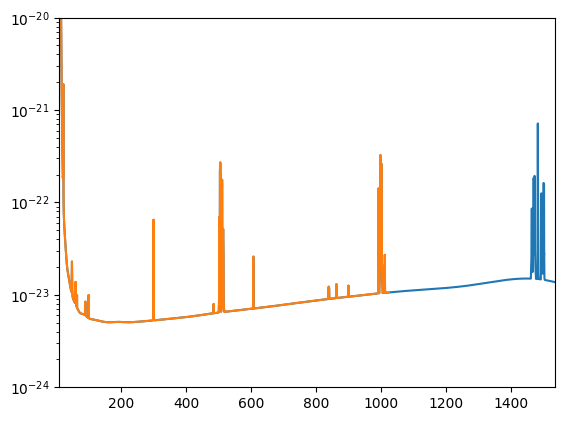

In [69]:
plt.plot(asd_dataset.domain(), asd)
plt.plot(ufd(), asd_ufd)
plt.yscale("log")
plt.xlim((10,1536))
plt.ylim((1e-24, 1e-20))
plt.show()

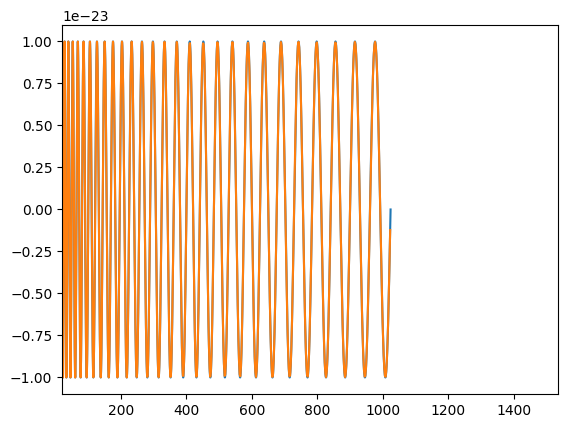

In [78]:
def period(x):
    return 1 / (np.sqrt(x) + 1e-10)

h_ufd = np.sin(2 * np.pi * ufd() * period(ufd())) + 1j * np.cos(2 * np.pi * ufd() * period(ufd()))
h_ufd *= 1e-23
# h_ufd = h_ufd * asd_ufd

h_mfd = np.sin(2 * np.pi * mfd() * period(mfd())) + 1j * np.cos(2 * np.pi * mfd() * period(mfd()))
h_mfd *= 1e-23
# h_mfd = h_mfd * asd_mfd

plt.plot(ufd(), h_ufd)
plt.plot(mfd(), mfd.decimate(h_ufd))
plt.xlim((20,1536))
# plt.ylim((-1e-22, 1e-22))
plt.show()

In [79]:
asd_dec = 1 / mfd.decimate(1 / asd_ufd)
asd_dec_naive = mfd.decimate(asd_ufd)

# In dingo training, we start with a waveform, which is already in mfd, we then whiten it.
h_mfd_white = h_mfd / asd_dec
h_mfd_white_naive = h_mfd / asd_dec_naive

# In dingo inference, we have a in the original domain (+ colored noise, which we
# ignore here).
#   - whiten in original domain
#   - decimate to mfd
h_ufd_white = h_ufd / asd_ufd
h_ufd_white_dec = mfd.decimate(h_ufd_white)

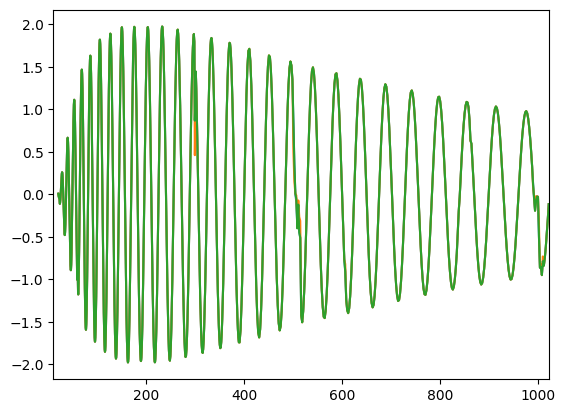

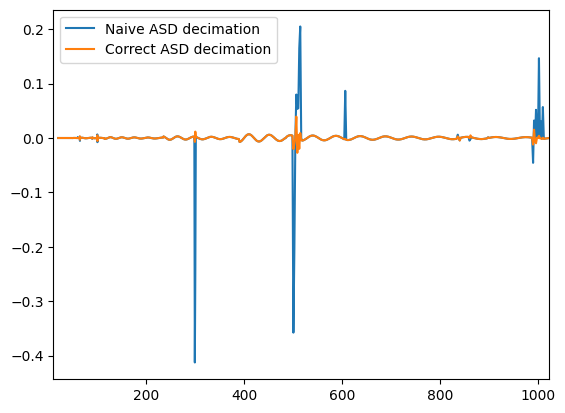

In [95]:
plt.plot(mfd(), h_ufd_white_dec)
plt.plot(mfd(), h_mfd_white_naive)
plt.plot(mfd(), h_mfd_white)
plt.xlim((10,1024))
plt.show()

plt.plot(mfd(), h_mfd_white_naive - h_ufd_white_dec, label="Naive ASD decimation")
plt.plot(mfd(), h_mfd_white - h_ufd_white_dec, label="Correct ASD decimation")
plt.xlim((10,1024))
plt.legend()
plt.show()

In [88]:
print("Mismatches:")
print(
    f"Correct ASD decimation: {get_mismatch(h_ufd_white_dec, h_mfd_white, mfd):.2e}"
)
print(
    f"Naive ASD decimation:   {get_mismatch(h_ufd_white_dec, h_mfd_white_naive, mfd):.2e}"
)

Mismatches:
Correct ASD decimation: 1.77e-06
Naive ASD decimation:   2.44e-04
